In [14]:
import gc
import sklearn
import numpy as np
import pandas as pd
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.utils import io

from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.neighbors import LocalOutlierFactor, KNeighborsRegressor
from sklearn.feature_selection import (
    RFE,
    RFECV, 
    VarianceThreshold, 
    SelectKBest, 
    mutual_info_regression, 
    f_regression, 
    SelectFromModel,
    f_classif,
    chi2
)

from sklearn.metrics import f1_score, confusion_matrix

from sklearn.preprocessing import (
    QuantileTransformer, 
    RobustScaler, 
    MinMaxScaler, 
    StandardScaler
)

from sklearn.model_selection import (
    RepeatedKFold, 
    RepeatedStratifiedKFold, 
    train_test_split, 
    cross_val_score
)

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import RidgeClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import (
    RationalQuadratic, 
    WhiteKernel, 
    Matern, 
    ExpSineSquared, 
    DotProduct, 
    RBF
)

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    RandomForestClassifier,
    RandomForestRegressor,
    IsolationForest,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)

from xgboost import XGBClassifier

In [11]:
SEED = 42

## TaskSolver object

In [12]:
class TaskSolver:
    def __init__(
        self, 
        train_df,
        test_df,
        imputer,
        outliers_detector,
        scaler,
        corr_threshold,
    ):
        self.train_df = train_df
        self.train_features = train_df.drop(["id", "y", "fold"], axis=1).to_numpy(dtype="float32")
        self.train_targets = train_df["y"].to_numpy()
        self.train_folds = train_df["fold"].to_numpy()
        self.test_df = test_df
        self.test_features = test_df.drop(["id"], axis=1).to_numpy(dtype="float32")
        
        self.imputer = imputer
        self.outliers_detector = outliers_detector
        self.scaler = scaler
        self.corr_threshold = corr_threshold
        self.resampler = RandomOverSampler(
            sampling_strategy="auto", 
            shrinkage=3,
            random_state=SEED
        )
    
    def _count_missing_values(self, x):
        missing_count = np.count_nonzero(np.isnan(x))
        total_entries = x.shape[0] * x.shape[1]
        missing_pct = missing_count / total_entries
        print(f"Total missing values: {missing_count}/{total_entries} ({missing_pct*100:.3f}%)")
        return missing_pct

    def _handling_missing_values(self):
        self._count_missing_values(self.train_features)
        self._count_missing_values(self.test_features)
        print("Imputing missing values...")
        
        self.imputer.fit(self.train_features)
        self.train_features = self.imputer.transform(self.train_features)
        self.test_features = self.imputer.transform(self.test_features)
        assert self._count_missing_values(self.train_features) == 0.0
        assert self._count_missing_values(self.test_features) == 0.0
    
    def _detect_and_remove_outliers(self):
        classes = [0, 1, 2, 3]
        new_train_features = np.array([]).reshape(0, self.train_features.shape[1])
        new_train_targets = np.array([])
        new_train_folds = np.array([])
        for c in classes:
            mask = (self.train_targets == c)
            class_samples = self.train_features[mask]
            class_targets = self.train_targets[mask]
            class_folds = self.train_folds[mask]
            num_samples = class_samples.shape[0]
            outlier_detector = IsolationForest(random_state=SEED)
            y = outlier_detector.fit_predict(class_samples)
            outlier_count = sum(y == -1)
            outlier_pct = outlier_count / num_samples
            # print(f"Class {c} has {outlier_count} outliers. ({outlier_pct*100:.5f}%)")
            scores = outlier_detector.decision_function(class_samples)
            remove_pct = min(0.01, outlier_pct) # Remove 1% outliers
            remove_count = int(num_samples * remove_pct)
            remove_indices = np.argpartition(scores, kth=remove_count)[:remove_count]
            print(f"Remove {remove_count} outliers from class {c}")
            new_train_features = np.vstack((new_train_features, np.delete(class_samples, remove_indices, axis=0)))
            new_train_targets = np.concatenate((new_train_targets, np.delete(class_targets, remove_indices)))
            new_train_folds = np.concatenate((new_train_folds, np.delete(class_folds, remove_indices)))
            del outlier_detector
            gc.collect()
            
        self.train_features = new_train_features
        self.train_targets = new_train_targets
        self.train_folds = new_train_folds
        print(
            "Train shape:", self.train_features.shape, 
            "Train target shape:", self.train_targets.shape,
            "Train fold shape:", self.train_folds.shape,
        )
    
    def _normalize_data(self):
        print("Rescaling data...")
        self.scaler.fit(self.train_features)
        self.train_features = self.scaler.transform(self.train_features)
        self.test_features = self.scaler.transform(self.test_features)
    
    def _corr2_coeff(self, A, B):
        # credit: https://stackoverflow.com/a/30143754/7053239
        # Rowwise mean of input arrays & subtract from input arrays themeselves
        A_mA = A - A.mean(1)[:, None]
        B_mB = B - B.mean(1)[:, None]
        # Sum of squares across rows
        ssA = (A_mA ** 2).sum(1)
        ssB = (B_mB ** 2).sum(1)
        # Finally get corr coeff
        return np.dot(A_mA, B_mB.T) / np.sqrt(np.dot(ssA[:, None], ssB[None]))

    def _remove_redundant_features(self):
        print("Removing zero-variance features...")
        self.var_selector = VarianceThreshold(threshold=0)
        self.var_selector.fit(self.train_features)
        self.train_features = self.var_selector.transform(self.train_features)
        self.test_features = self.var_selector.transform(self.test_features)
        print("Train shape:", self.train_features.shape, "Test shape:", self.test_features.shape)
        
        # print("Removing highly correlated features...")
        # cor = self._corr2_coeff(self.train_features.T, self.train_features.T)
        # correlated_pairs = np.argwhere(np.triu(np.absolute(cor) >= self.corr_threshold, 1))
        # self.train_features = np.delete(self.train_features, correlated_pairs[:, 1], axis=1)
        # self.test_features = np.delete(self.test_features, correlated_pairs[:, 1], axis=1)
        # print("Train shape:", self.train_features.shape, "Test shape:", self.test_features.shape)

    def _prepare_kfold(self):
        self.fold_train_features = []
        self.fold_train_targets = []
        self.fold_sample_weights = []
        self.fold_val_features = []
        self.fold_val_targets = []
        for fold_nr in range(5):
            val_mask = (self.train_folds == fold_nr)
            x_train = self.train_features[~val_mask]
            y_train = self.train_targets[~val_mask]
            x_val = self.train_features[val_mask]
            y_val = self.train_targets[val_mask]
            sample_weight = compute_sample_weight(class_weight="balanced", y=y_train)
            self.fold_train_features.append(x_train)
            self.fold_train_targets.append(y_train)
            self.fold_sample_weights.append(sample_weight)
            self.fold_val_features.append(x_val)
            self.fold_val_targets.append(y_val)

    def preprocessing(self):
        self._handling_missing_values()
        self._detect_and_remove_outliers()
        self._normalize_data()
        self._remove_redundant_features()
        self._prepare_kfold()
    
    def feature_selection(self, selector):
        print("Selecting features...")
        self.feature_selector = selector
        self.feature_selector.fit(self.train_features, self.train_targets)
        self.train_features = self.feature_selector.transform(self.train_features)
        self.test_features = self.feature_selector.transform(self.test_features)
        print("Train shape:", self.train_features.shape, "Test shape:", self.test_features.shape)

    def _round_to_nearest_int(self, x):
        decimal = x % 1
        mask = abs(x - np.round(x)) <= self.rounding_threshold
        x[mask] = np.round(x[mask])
        return x

    def _cross_validation(self, model):
        scores = []
        self.oof_preds = []
        self.oof_targets = []
        for fold_nr in range(5):
            x_train = self.fold_train_features[fold_nr]
            y_train = self.fold_train_targets[fold_nr]
            sample_weight = self.fold_sample_weights[fold_nr]
            x_val = self.fold_val_features[fold_nr]
            y_val = self.fold_val_targets[fold_nr]
            model = model.fit(x_train, y_train, sample_weight=sample_weight)
            pred_val = model.predict(x_val)
            scores.append(f1_score(y_val, pred_val, average='micro'))
            self.oof_preds.extend(pred_val.tolist())
            self.oof_targets.extend(y_val.tolist())

        return scores
    
    def _save_oof_prediction(self):
        oof = pd.DataFrame()
        oof["y_pred"] = self.oof_preds
        oof["y"] = self.oof_targets
        oof.to_csv(f"submissions/{self.timestamp}.oof.csv", index=False)

    def _get_oof_confusion_matrix(self):
        cf_matrix = confusion_matrix(self.oof_targets, self.oof_preds)
        sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

    def train(self, model, verbose=True):
        self.timestamp = datetime.now().strftime("%Y_%m_%d-%I:%M:%S")
        scores = self._cross_validation(sklearn.base.clone(model))
        
        if verbose: 
            print("F1: {:.5f} ± {:.5f}".format(np.mean(scores), np.std(scores)))
            self._get_oof_confusion_matrix()

        return np.mean(scores)

    def predict_test(self, model):
        sample_weight = compute_sample_weight(class_weight="balanced", y=self.train_targets)
        model.fit(self.train_features, self.train_targets, sample_weight=sample_weight)
        pred = model.predict(self.test_features)
        submission = pd.DataFrame()
        submission["id"] = self.test_df["id"]
        submission["y"] = pred
        submission.to_csv(f"submissions/{self.timestamp}.csv", index=False)
        self._save_oof_prediction()

## Feature preprocessing & selection

In [13]:
solver = TaskSolver(
    train_df=pd.read_csv("data/kfold.csv"),
    test_df=pd.read_csv("data/test_features.csv"),
    imputer=IterativeImputer(
        estimator=RandomForestRegressor(
            n_estimators=10,
            max_depth=10,
            bootstrap=True,
            max_samples=0.5,
            random_state=SEED
        ),
        max_iter=10,
        n_nearest_features=35,
        initial_strategy="median", 
        random_state=SEED, 
        verbose=0
    ),
    outliers_detector=IsolationForest(random_state=SEED),
    scaler=QuantileTransformer(output_distribution="normal"),
    corr_threshold=0.97,
)

solver.preprocessing()

Total missing values: 29987/429828 (6.977%)
Total missing values: 18002/286524 (6.283%)
Imputing missing values...
Total missing values: 0/429828 (0.000%)
Total missing values: 0/286524 (0.000%)
Remove 30 outliers from class 0
Remove 4 outliers from class 1
Remove 14 outliers from class 2
Remove 1 outliers from class 3
Train shape: (5068, 84) Train target shape: (5068,) Train fold shape: (5068,)
Rescaling data...
Removing zero-variance features...
Train shape: (5068, 84) Test shape: (3411, 84)


## Tune models

In [16]:
def objective(trial):
    # model = XGBClassifier(
    #     **{
    #         'objective': 'multi:softmax',
    #         'tree_method': 'auto',
    #         'random_state': SEED,
    #         'lambda': trial.suggest_float(
    #             'lambda', 0.1, 100.0
    #         ),
    #         'alpha': trial.suggest_float(
    #             'alpha', 1e-3, 10.0
    #         ),
    #         'colsample_bytree': trial.suggest_categorical(
    #             'colsample_bytree', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #         ),
    #         'colsample_bylevel': trial.suggest_categorical(
    #             'colsample_bylevel', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #         ),
    #         'subsample': trial.suggest_categorical(
    #             'subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    #         ),
    #         'learning_rate': trial.suggest_float(
    #             'learning_rate', 1e-3, 0.5
    #         ),
    #         'n_estimators': trial.suggest_categorical(
    #             "n_estimators", [50, 100, 150, 300, 500, 1000, 3000]
    #         ),
    #         'max_depth': trial.suggest_int(
    #             'max_depth', 5, 15
    #         ),
    #         'min_child_weight': trial.suggest_int(
    #             'min_child_weight', 1, 50
    #         ),
    #     }
    # )

    model = RandomForestClassifier(
        **{
            'bootstrap': trial.suggest_categorical("bootstrap", [True, False]),
            'max_depth': trial.suggest_categorical("max_depth", [10, 50, 100, 150, 200]),
            'max_features': trial.suggest_categorical("max_features", ["sqrt", "log2"]),
            'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 10),
            'min_samples_split': trial.suggest_int("min_samples_split", 2, 10),
            'n_estimators': trial.suggest_categorical("n_estimators", [10, 50, 100, 150, 300, 500, 1000]),
        },
        random_state=SEED
    )

    cv_score = solver.train(model, verbose=False)
    return cv_score

study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=100)

[I 2022-12-04 18:06:48,273] A new study created in memory with name: no-name-36eb2f21-e338-4135-8450-162af29c2a27
[I 2022-12-04 18:11:09,117] Trial 0 finished with value: 0.7721020569536142 and parameters: {'bootstrap': False, 'max_depth': 150, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}. Best is trial 0 with value: 0.7721020569536142.
[I 2022-12-04 18:11:26,599] Trial 1 finished with value: 0.7239240207913473 and parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 9, 'min_samples_split': 10, 'n_estimators': 100}. Best is trial 0 with value: 0.7721020569536142.
[I 2022-12-04 18:12:05,633] Trial 2 finished with value: 0.7715089791465981 and parameters: {'bootstrap': False, 'max_depth': 50, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 150}. Best is trial 0 with value: 0.7721020569536142.
[I 2022-12-04 18:13:06,826] Trial 3 finished with value: 0.73457619386

KeyboardInterrupt: 

In [120]:
study.best_params

{'lambda': 8.204888056119929,
 'alpha': 1.602247689318723,
 'colsample_bytree': 0.7,
 'colsample_bylevel': 1.0,
 'subsample': 0.9,
 'learning_rate': 0.37830598406476423,
 'n_estimators': 500,
 'max_depth': 13,
 'min_child_weight': 3}

In [ ]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_param_importances(study)

F1: 0.78631 ± 0.00667


0.7863076894732689

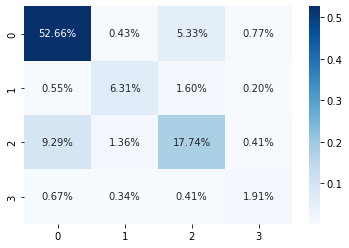

In [9]:
# model = RandomForestClassifier(
#     **{
#         'bootstrap': False,
#         'max_depth': 150,
#         'max_features': 'sqrt',
#         'min_samples_leaf': 1,
#         'min_samples_split': 7,
#         'n_estimators': 1000
#     },
#     random_state=SEED
# )

# model = XGBClassifier(
#     **{
#         'lambda': 8.204888056119929,
#         'alpha': 1.602247689318723,
#         'colsample_bytree': 0.7,
#         'colsample_bylevel': 1.0,
#         'subsample': 0.9,
#         'learning_rate': 0.37830598406476423,
#         'n_estimators': 500,
#         'max_depth': 13,
#         'min_child_weight': 3
#     },
#     objective="multi:softproba",
#     tree_method="auto",
#     random_state=SEED,
# )

# model = KNeighborsClassifier(
#     **{'n_neighbors': 21, 'weights': 'distance', 'leaf_size': 59}
# )

# model = SVC(
#     **{'C': 44.323830214854965, 'kernel': 'rbf', 'gamma': 'scale'}
# )

# model = MLPClassifier(
#     **{
#         "hidden_layer_sizes": (32, 128, 32),
#         'activation': 'relu',
#         'alpha': 0.004899987485256258,
#         'learning_rate': 'constant',
#         'learning_rate_init': 0.005383029783625564,
#         "max_iter": 1000,
#         "random_state": SEED,
#         "early_stopping": True
#     }
# )

# model = RidgeClassifier(alpha=10)

solver.train(model)

### True class distribution
Class 0 occupies 59.21438%  
Class 1 occupies 8.65742%  
Class 2 occupies 28.80594%  
Class 3 occupies 3.32226%

In [116]:
solver.predict_test(model)